In [1]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import numpy as np
import xarray as xr 
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.time import Time
from scipy import interpolate
from scipy.interpolate import Rbf
from scipy import signal
from PIL import Image
from read_ICESat2.read_ICESat2_ATL07 import read_HDF5_ATL07
from read_ICESat2.read_ICESat2_ATL10 import read_HDF5_ATL10
import warnings
import cartopy.crs as ccrs
import cartopy
from matplotlib.colors import LightSource
from matplotlib import ticker
import glob
import logging, sys
from datetime import date
import datetime 
from multiprocessing.pool import Pool
from astropy.time import Time
from tqdm.notebook import tqdm
from pyproj import Proj, transform
from pyproj import CRS
import gps_time
import re
import json
import pickle
import statistics as stat
import sys 
import os
import geopy.distance
import cmocean
from scipy.interpolate import griddata
from geographiclib.geodesic import Geodesic
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import LinearRing
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import seaborn as sns

warnings.filterwarnings('ignore')
logging.disable(sys.maxsize)
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'read_ICESat2'

In [ ]:
def reproject(x, y, in_epsg, out_epsg):
    inProj = Proj(init = in_epsg)
    outProj = Proj(init = out_epsg)
    xout,yout = transform(inProj,outProj,x,y)
    return xout,yout

def segment_coordinates(lon0,lat0,lon1,lat1,seg_length):
    bearing = Geodesic.WGS84.Inverse(lat0,lon0,lat1,lon1)['azi1']
    end = geopy.distance.distance(meters=seg_length/2).destination((lat0,lon0), bearing=bearing)
    start = geopy.distance.distance(meters=seg_length/2).destination((lat0,lon0), bearing=bearing+180.0)
    return start[0:2], end[0:2] 

def ATL07_h5_to_gdf(file_list):
    atlas_sdp_gps_epoch = 1198800018.0
    gdf_list=list()
    for file in file_list:
        IS2_atl07_mds,IS2_atl07_attrs,IS2_atl07_beams = read_HDF5_ATL07(file)
        beam_list = list()
        for beam in IS2_atl07_beams:    
            tmp = pd.DataFrame.from_dict(IS2_atl07_mds[beam]['sea_ice_segments']['geophysical'])
            tmp['height_segment_height'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_height']
            tmp['height_segment_length_seg'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_length_seg']
            tmp['height_segment_n_pulse_seg_used'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_n_pulse_seg_used']            
            tmp['height_segment_ssh_flag'] = IS2_atl07_mds[beam]['sea_ice_segments']['heights']['height_segment_ssh_flag']
            tmp['hist_photon_heights'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_heights'].tolist()  
            tmp['hist_mean_h'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_mean_h']   
            tmp['hist_median_h'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_median_h']   
            tmp['hist_photon_bin_size'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_bin_size']   
            tmp['hist_photon_bottom'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_bottom']   
            tmp['hist_photon_top'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_photon_top']   
            tmp['hist_w'] = IS2_atl07_mds[beam]['sea_ice_segments']['stats']['hist_w']   
            tmp['delta_time'] = IS2_atl07_mds[beam]['sea_ice_segments']['delta_time']
            tmp['longitude']= IS2_atl07_mds[beam]['sea_ice_segments']['longitude']
            tmp['latitude']= IS2_atl07_mds[beam]['sea_ice_segments']['latitude']
            tmp['height_segment_id'] = IS2_atl07_mds[beam]['sea_ice_segments']['height_segment_id']
            tmp['beam'] = beam
            beam_list.append(tmp)
        
        df = pd.concat([df for df in beam_list]).pipe(gpd.GeoDataFrame)
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf_list.append(gdf)   
                        
    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)    
    gdf_final['ATL_time'] = Time(gdf_final.delta_time+atlas_sdp_gps_epoch, format='gps').to_datetime()
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)

def ATL10_h5_to_gdf(file_list):
    gdf_list=list()
    for file in file_list:
        IS2_atl10_mds,IS2_atl10_attrs,IS2_atl10_beams = read_HDF5_ATL10(file)
        beam_list = list()
        for beam in IS2_atl10_beams:    
            tmp = pd.DataFrame.from_dict(IS2_atl10_mds[beam]['freeboard_beam_segment']['beam_freeboard'])
            tmp['beam'] = beam
            beam_list.append(tmp)
            
        df = pd.concat([df for df in beam_list]).pipe(gpd.GeoDataFrame)
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf = gdf[(gdf['beam_fb_height'] < 10.0) &
                  (gdf['latitude'] > 50.0) ]
        gdf_list.append(gdf)   
                        
    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)
    

def ALS_to_gdf(file_list):
    gdf_list=list()
    for file in file_list:
        print(file)
        ds = xr.open_dataset(file)
        ds = ds.drop_dims(["time","time_bnds","grid_mapping"])
        df = ds.to_dataframe()
        gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.lon, df.lat),crs=4326)
        gdf = gdf.to_crs(3413)
        gdf_list.append(gdf)   

    gdf_final = pd.concat([gdf for gdf in gdf_list]).pipe(gpd.GeoDataFrame)
    gdf_final.crs = (gdf_list[0].crs)
        
    return gdf_final.reset_index(drop=True)

def cbLike_to_csv(path_in, path_out):
    ALSlist = sorted(glob.glob(path_in + '*.nc'))
    cb_list=[]
    for file in ALSlist:
        gdf_final = ALS_to_gdf([file])
        gdf_final = gdf_final.dropna(how='any')
        gdf_final = gdf_final.sort_values(by=['timestamp']).reset_index(drop=True)
        d = {'lon': gdf_final.lon.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True),
             'lat': gdf_final.lat.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True),
             'ALS_time':pd.to_datetime(gdf_final.timestamp.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True), unit='s'),
             'elevation':gdf_final.elevation.rolling(5000, min_periods=1).mean()[30000:-30000:10000].reset_index(drop=True)}
        cb_list.append(pd.DataFrame(data=d))

    cbLike = pd.concat([gdf for gdf in cb_list]).pipe(gpd.GeoDataFrame)
    cbLike.to_csv('/Users/rricker/Data/IS2/cbLike_track.csv',index=False)

def join_ATL_ALS(ALSlist,ATL07_gdf):
    data_list = list()
    
    for j in range(0,len(ALSlist)):
        # load 2 subsequent ALS grids to ensure overlap, to avoid partially filled ATL foorptints,
        # duplicates will be deleted
        ALS_gdf = ALS_to_gdf(ALSlist[j:j+2])
        ALS_gdf = ALS_gdf[np.isnan(ALS_gdf.elevation)!=True].reset_index(drop=True)

        ATL07_gdfs = ATL07_gdf[(ATL07_gdf["latitude"]<ALS_gdf["lat"].max()) &
                               (ATL07_gdf["latitude"]>ALS_gdf["lat"].min()) &
                               (ATL07_gdf["longitude"]<ALS_gdf["lon"].max()) &
                               (ATL07_gdf["longitude"]>ALS_gdf["lon"].min())].reset_index(drop=True)

        ATL07_gdfs.crs = 4326
        seg_start =[]
        seg_end =[]
        Linestr = []
        for i in range(0,len(ATL07_gdfs)):
            if i < len(ATL07_gdfs)-1:
                ps, pe = segment_coordinates(ATL07_gdfs.longitude[i],ATL07_gdfs.latitude[i],
                                             ATL07_gdfs.longitude[i+1],ATL07_gdfs.latitude[i+1],
                                             ATL07_gdfs.height_segment_length_seg[i])
            else:
                ps, pe = segment_coordinates(ATL07_gdfs.longitude[i],ATL07_gdfs.latitude[i],
                                             ATL07_gdfs.longitude[i-1],ATL07_gdfs.latitude[i-1],
                                             ATL07_gdfs.height_segment_length_seg[i])

            seg_start.append(ps)
            seg_end.append(pe)
            Linestr.append(LineString([(ps[1],ps[0]),(pe[1],pe[0])]))

        ATL07_gdfs['segment_start'] = seg_start
        ATL07_gdfs['segment_end'] = seg_end
        ATL07_gdfs['segment_center_point'] = ATL07_gdfs['geometry']
        ATL07_gdfs['geometry'] = Linestr
        ATL07_gdfs = ATL07_gdfs.to_crs("EPSG:3413")
        ATL07_gdfs["geometry"] = ATL07_gdfs.geometry.buffer(6.5)
        footprint = gpd.GeoDataFrame(crs=3413, geometry=ATL07_gdfs["geometry"] )
        pointsinside = gpd.sjoin(ALS_gdf,footprint,how="inner").reset_index(drop=True)

        ALS=pointsinside.groupby(pointsinside.index_right).mean()
        ALS['n_points'] = pointsinside.groupby(pointsinside.index_right).elevation.count() 
        ALS.reset_index(inplace=True)

        ALS['pointsinside']=''
        ALS['n_pointsinside']=''
        
        for i in ALS.index_right.unique():
            tmp = pointsinside[pointsinside.index_right==i].drop(['index_right',
                                                                  'timestamp',
                                                                  'n_points',
                                                                  'elevation_reference',
                                                                  'echo_width'],axis=1).reset_index(drop=True)
            ALS.pointsinside[ALS.index[ALS.index_right==i][0]] = tmp
            ALS.n_pointsinside[ALS.index[ALS.index_right==i][0]] = tmp.elevation.count()

        ATL=ATL07_gdfs.iloc[ALS.index_right.unique()].reset_index(drop=True)
        ALS = ALS[['timestamp','elevation','elevation_reference','reflectance',
                   'echo_width','freeboard','pointsinside','n_pointsinside']]
        ALS.rename(columns={"elevation": "ALS_elevation",
                            "elevation_reference": "ALS_elevation_reference",
                            "freeboard": "ALS_freeboard",
                            "reflectance": "ALS_reflectance",
                            "echo_width": "ALS_echo_width"},inplace=True)

        ATL = ATL[['ATL_time','height_segment_height','height_segment_id',
                   'height_segment_length_seg','height_segment_n_pulse_seg_used',
                   'hist_photon_heights','hist_photon_bin_size','hist_photon_bottom','hist_photon_top',
                   'hist_mean_h','hist_median_h','hist_w',
                   'longitude','latitude','beam','segment_center_point','geometry']]
        
        ATL.rename(columns={"height_segment_height": "ATL_elevation"},inplace=True)

        ALS['ALS_time'] = pd.to_datetime(ALS['timestamp'], unit='s')
        ALS.drop('timestamp', axis=1, inplace=True)

        data_list.append(pd.concat([ATL, ALS], axis=1))

        del ALS_gdf, ATL07_gdfs, ALS, ATL, footprint, pointsinside

    data = pd.concat([gdf for gdf in data_list]).pipe(gpd.GeoDataFrame)

    data_gt2l = data[data["beam"]=='gt2l'].reset_index(drop=True).sort_values(by=['ALS_time']).reset_index(drop=True)
    data_gt2l.drop_duplicates(subset=['height_segment_id'], keep='first', inplace=True)
    data_gt2l = data_gt2l[(data_gt2l['n_pointsinside'] > 2500)]
    data_gt2l.reset_index(drop=True, inplace=True)
                          
    data_gt2r = data[data["beam"]=='gt2r'].reset_index(drop=True).sort_values(by=['ALS_time']).reset_index(drop=True)
    data_gt2r.drop_duplicates(subset=['height_segment_id'], keep='first', inplace=True)
    data_gt2r = data_gt2r[(data_gt2r['n_pointsinside'] > 1000)]
    data_gt2r.reset_index(drop=True, inplace=True)

    tmp = gpd.GeoDataFrame(geometry=data_gt2l.segment_center_point)
    data_gt2l['distance_along_track'] = tmp.distance(tmp.shift(1)).cumsum(axis = 0)
    data_gt2l['distance_along_track'][0]=0
    tmp = gpd.GeoDataFrame(geometry=data_gt2r.segment_center_point)
    data_gt2r['distance_along_track'] = tmp.distance(tmp.shift(1)).cumsum(axis = 0)
    data_gt2r['distance_along_track'][0]=0
    
    return data_gt2l, data_gt2r

def get_ALS_ssh(ALSlist):
    ssh_list = list()

    for file in ALSlist:
        ALS_gdf = ALS_to_gdf([file])
        ALS_gdf = ALS_gdf.dropna(how='any').reset_index(drop=True)
        ALS_gdf = ALS_gdf[ALS_gdf.elevation < ALS_gdf.elevation.quantile(.10)]
        ALS_ssh = ALS_gdf[ALS_gdf.reflectance < -12]
        if len(ALS_ssh)!=0: 
            ALS_ssh[(ALS_ssh.elevation > ALS_ssh.elevation.quantile(.25))&
                    (ALS_ssh.elevation < ALS_ssh.elevation.quantile(.75))]
            ALS_ssh
            if len(ALS_ssh)!=0: 
                ssh_list.append(ALS_ssh.mean().to_frame().T)

    ALS_ssh = pd.concat([gdf for gdf in ssh_list]).pipe(gpd.GeoDataFrame).reset_index(drop=True)
    ALS_ssh['ALS_time'] = pd.to_datetime(ALS_ssh.timestamp, unit='s')
    
    return ALS_ssh

def get_ALS_openwater(ow_file):
    ow = pd.read_csv(ow_file)
    ow['ALS_time'] = pd.to_datetime(ow['timestamp'], unit='s')
    return ow

    


In [7]:
%%time
#read ATL07 and write into geodataframe

ATL07file = list(["/Users/rricker/Data/IS2/ATL07-01_20200323105252_13400601_005_01.h5"])
ATL07_gdf = ATL07_h5_to_gdf(ATL07file)  

CPU times: user 22.8 s, sys: 6.63 s, total: 29.4 s
Wall time: 36.9 s


In [ ]:
%%time
#read ATL010 and write into geodataframe
ATL10file = list(["/Users/rricker/Data/IS2/ATL10-01_20200323105252_13400601_005_02.h5"])
ATL10_gdf = ATL10_h5_to_gdf(ATL10file)  

tmp = gpd.GeoDataFrame(geometry=ATL10_gdfs.geometry)
ATL10_gdfs['distance_along_track'] = tmp.distance(tmp.shift(1)).cumsum(axis = 0)
    

In [5]:
%%time
#merge ATL07 and ALS, search for ALS data within ATL07 segments and calculate footprint 

ALSpath = "/Users/rricker/Data/IS2/tds-is2/l4-grid-v2/"
ALSlist = sorted(glob.glob(ALSpath + '*.nc'))
#ALSlist=ALSlist[61:62]

#data_gt2l, data_gt2r = join_ATL_ALS(ALSlist,ATL07_gdf)

#data_gt2l.to_pickle('/Users/rricker/Data/IS2/data_gt2l.pkl')
#data_gt2r.to_pickle('/Users/rricker/Data/IS2/data_gt2r.pkl')

data_gt2l = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2l.pkl')
data_gt2r = pd.read_pickle('/Users/rricker/Data/IS2/data_gt2r.pkl')

CPU times: user 17.1 s, sys: 8.79 s, total: 25.9 s
Wall time: 33.1 s


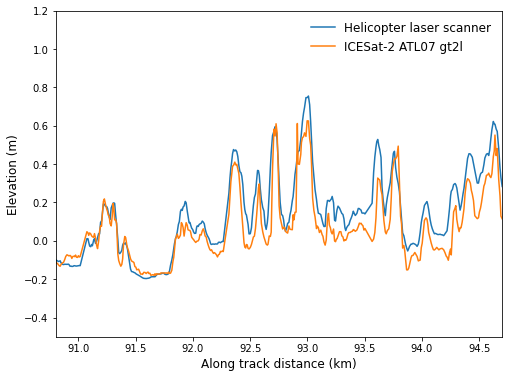

In [5]:
elev = data_gt2l.ALS_elevation#-data_gt2l.ssh_interpolated

fontsize = 12

fig, ax = plt.subplots(figsize=(8,6),facecolor='white')
ax.set_xlabel("Along track distance (km)",fontsize=fontsize)
ax.set_ylabel("Elevation (m)",fontsize=fontsize)
ax.set_xlim(90.8,94.7)
ax.set_ylim(-0.5,1.2)
#ax.set_ylim(-2,1)
ax.plot(data_gt2l['distance_along_track']/1000.0,elev+1.44,  label='Helicopter laser scanner')
ax.plot(data_gt2l['distance_along_track']/1000.0,data_gt2l['ATL_elevation'],label='ICESat-2 ATL07 '+data_gt2l.beam[0])
#ax.plot(data_gt2l['distance_along_track']/1000.0,data_gt2l['ALS_freeboard'],label='ALS freeboard '+data_gt2l.beam[0])


#ax.scatter(data_gt2r['distance_along_track']/1000.0,data_gt2l['ALS_ssh']-18,label='ALS ssh',color='b',zorder=5)
#ax.plot(data_gt2r['distance_along_track']/1000.0,data_gt2r['height_segment_height'],label='ICESat-2 ATL07 '+data_gt2r.beam[0])

legend = ax.legend(fontsize=fontsize)
legend.get_frame().set_linewidth(0)

#ax = data_gt2l.elevation.plot(color='orange',figsize=(15,8))
#ax = elev.plot(color='orange',figsize=(15,8))
#data_gt2l.height_segment_height.plot(ax=ax,color='blue')

#pearsonr(data.elevation,data.height_segment_height)

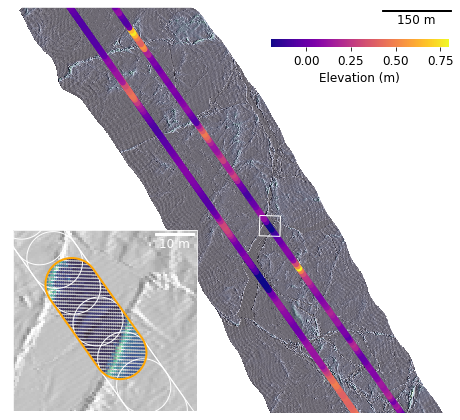

In [25]:
ALSpath = "/Users/rricker/Data/IS2/tds-is2/l4-grid-v2/"
ALSlist = sorted(glob.glob(ALSpath + '*.nc'))
file= ALSlist[61:62][0]
ds = xr.open_dataset(file)
elev = np.array(ds.elevation)

int_elev = elev
int_elev[np.isnan(int_elev)==True]=-2
ls = LightSource(azdeg=270,altdeg=35)
intensity = ls.hillshade(int_elev, vert_exag=2.5)
intensity[int_elev==-2]=np.nan
intensity[intensity<0.4]=np.nan

fig = plt.figure(figsize=(8, 8))
projection = ccrs.Stereographic(central_latitude=86.0, central_longitude=13.0, true_scale_latitude=70)
ax = plt.axes(projection=projection)

e_lon = np.array(ds.lon).flatten()[np.isnan(np.array(ds.elevation).flatten())!=True]
e_lat = np.array(ds.lat).flatten()[np.isnan(np.array(ds.elevation).flatten())!=True]

ax.set_extent([e_lon.min(), e_lon.max(), e_lat.min()+0.0017, e_lat.max()-0.0017])

ax.outline_patch.set_edgecolor('white')

ax.pcolormesh(ds.xc,ds.yc,intensity,cmap="Greys",transform=projection,snap=True)
ax.pcolormesh(ds.xc,ds.yc,np.array(ds.elevation),cmap=cmocean.cm.deep_r,alpha=0.3,transform=projection,snap=True)

data_gt2l = data_gt2l.to_crs(4326)
data_gt2r = data_gt2r.to_crs(4326)
data_gt2l.plot(ax=ax,column='ATL_elevation',cmap="plasma",
               aspect='equal',vmin=-0.2,vmax=0.8,transform=ccrs.PlateCarree())
data_gt2r.plot(ax=ax,column='ATL_elevation',cmap="plasma",
               aspect='equal',vmin=-0.2,vmax=0.8,transform=ccrs.PlateCarree())

box_xmin = 11.309
box_xmax = 11.316
box_ymin = 86.66165
box_ymax = 86.66205

x = [box_xmin, box_xmin, box_xmax, box_xmax]
y = [box_ymin, box_ymax, box_ymax, box_ymin]
roi = LinearRing(list(zip(x, y)))
ax.add_geometries([roi], ccrs.PlateCarree(), facecolor='none', edgecolor='white')

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           150, '150 m', 'upper right', 
                           pad=0.15,
                           color='black',
                           frameon=False,
                           size_vertical=4.0,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

cax = ax.inset_axes([0.59, 0.9, 0.4, 0.02], transform=ax.transAxes)
cb = plt.colorbar(ax.collections[2],ax=ax,shrink=0.7,orientation='horizontal',cax=cax)
cb.set_label(label='Elevation (m)',size=12)
cb.ax.tick_params(labelsize=12)
cb.outline.set_linewidth(0)

ax2 = fig.add_axes([0.135, 0.15, 0.32, 0.32],projection=projection)
ax2.set_extent([box_xmin, box_xmax, box_ymin, box_ymax])
ax2.outline_patch.set_edgecolor('white')
ax2.pcolormesh(ds.xc,ds.yc,intensity,cmap="Greys",transform=projection,alpha=0.5,snap=True)
#ax2.pcolormesh(ds.xc,ds.yc,np.array(ds.elevation),cmap=cmocean.cm.deep_r,alpha=0.2,transform=projection,snap=True)
plt.scatter(data_gt2r.pointsinside[2346].lon,
            data_gt2r.pointsinside[2346].lat,
            c=data_gt2r.pointsinside[2346].elevation,s=1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.deep_r)

data_gt2r[2343:2355].geometry.boundary.plot(color='white',edgecolor='k',linewidth = 1,
                                            ax=ax2,aspect='equal',transform=ccrs.PlateCarree())

data_gt2r[2346:2347].geometry.boundary.plot(color='orange',edgecolor='k',linewidth = 2,
                                            ax=ax2,aspect='equal',transform=ccrs.PlateCarree())

fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax2.transData,
                           10, '10 m', 'upper right', 
                           pad=0.15,
                           color='white',
                           frameon=False,
                           size_vertical=0.5,
                           fontproperties=fontprops)
ax2.add_artist(scalebar)


plt.savefig('overview2.png',dpi=300,bbox_inches='tight' )


In [2]:
import xarray as xr 
s1 = xr.open_rasterio('/Users/rricker/Data/IS2/S1/S1_EW_HH_sub_20200323T102552_20200323T102857_s1_400km_ps_50m_50.tiff')

NameError: name 'ATL07_gdf' is not defined

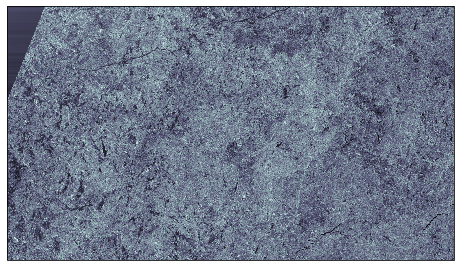

In [24]:
# overview figure 

xrange = (1100,4800)
yrange = (2800,4900)

bg_im = signal.detrend(s1[0][yrange[0]:yrange[1],xrange[0]:xrange[1]])
crs=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, false_easting=0.0, false_northing=0.0, true_scale_latitude=70.0)

ice_conc = netCDF4.Dataset("/Users/rricker/Data/IS2/ice_conc_nh_polstere-100_multi_202003231200.nc")
im = Image.open('/Users/rricker/Data/IS2/Heli.jpg')

tmp = {
"ice_conc": np.ma.getdata(ice_conc.variables["ice_conc"]).data[0,:,:],
"flag": np.ma.getdata(ice_conc.variables["status_flag"]).data[0,:,:],
"lon": np.ma.getdata(ice_conc.variables["lon"]).data,
"lat": np.ma.getdata(ice_conc.variables["lat"]).data}
tmp['xc'], tmp['yc'] = reproject(tmp["lon"], tmp["lat"], 'epsg:4326', 'epsg:3413')
tmp["ice_conc"][tmp["ice_conc"]<=0]=np.nan
dt_data_gt2l = data_gt2l.ALS_time-data_gt2l.ATL_time

xmin = s1.x[xrange[0]:xrange[1]].min()
xmax = s1.x[xrange[0]:xrange[1]].max()
ymin = s1.y[yrange[0]:yrange[1]].min()
ymax = s1.y[yrange[0]:yrange[1]].max()

fig=plt.figure(figsize=(8, 8))
ax = plt.axes(projection=crs)
ax.set_extent([xmin, xmax, ymin, ymax], crs=crs)

ax.pcolormesh(s1.x[xrange[0]:xrange[1]],s1.y[yrange[0]:yrange[1]],bg_im, cmap='bone',zorder=1)

atl07 = ax.plot(ATL07_gdf.longitude,ATL07_gdf.latitude,transform=ccrs.PlateCarree(),linewidth=0.5,
                linestyle='--',zorder=2,color='white',label='ICESat-2 beam pairs')

gt2l = ax.scatter(data_gt2l.longitude-0.15,data_gt2l.latitude-0.0075,transform=ccrs.PlateCarree(),
                  color='palegreen',marker='.',s=0.21,zorder=3,label='Overlap with gt2l')
gt2r = ax.scatter(data_gt2r.longitude+0.15,data_gt2r.latitude+0.0075,transform=ccrs.PlateCarree(),
                  color='skyblue',marker='.',s=0.21,zorder=4,label='Overlap with gt2r')

gt2l_delay = ax.scatter(data_gt2l.longitude,data_gt2l.latitude,c=dt_data_gt2l.dt.total_seconds()/60.0,vmin=-60,vmax=60,
                        transform=ccrs.PlateCarree(),cmap='PuOr_r',s=2,zorder=5)

ps = ax.plot([15.81100],[86.21143], marker='o',ms=8.0,transform=ccrs.PlateCarree(),zorder=6,color='white')
ps = ax.plot([15.81100],[86.21143], marker='+',ms=6.0,transform=ccrs.PlateCarree(),zorder=6,color='black')

ax2 = fig.add_axes([0.138, 0.51, 0.2, 0.2],projection=crs)
ax2.set_facecolor(mpl.cm.get_cmap('Blues_r')(0.0))
ax2.pcolormesh(tmp['xc'],tmp['yc'],tmp['ice_conc'], cmap=cmocean.cm.ice,transform=crs)
ax2.plot(ATL07_gdf[ATL07_gdf.beam=='gt2l'].longitude[::1000],ATL07_gdf[ATL07_gdf.beam=='gt2l'].latitude[::1000],
         transform=ccrs.PlateCarree(),linewidth=0.5,linestyle='--',color='black')
ax2.set_extent([0, 180, 60, 90])
ax2.coastlines(linewidth=0.3)
ax2.add_feature(cartopy.feature.LAND,facecolor='darkgray')    
x = [xmin, xmin, xmax, xmax]
y = [ymin, ymax, ymax, ymin]
roi = LinearRing(list(zip(x, y)))
ax2.add_geometries([roi], crs, facecolor='none', edgecolor='orange')

ax3 = fig.add_axes([0.723, 0.283, 0.17, 0.17],projection=crs)
ax3.imshow(im)

fontprops = fm.FontProperties(size=8)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           size_vertical=0.5,
                           fontproperties=fontprops)

ax.add_artist(scalebar)

cax = ax.inset_axes([0.015, 0.2, 0.2, 0.025], transform=ax.transAxes)
cb = plt.colorbar(gt2l_delay,ax=ax,orientation='horizontal',cax=cax)
cb.set_label(label='Delay (minutes)',size=8,color='white')
cb.ax.tick_params(labelsize=8,color='white')
cb.outline.set_linewidth(0)
cb.ax.xaxis.set_tick_params(color='white', labelcolor='white')
cb.locator = ticker.MaxNLocator(nbins=5)
cb.update_ticks()

leg = ax.legend(loc="upper right",fontsize=8,markerscale=10,labelcolor='white',
                facecolor='black',framealpha=0.4)

plt.savefig('overview1.png',dpi=300,bbox_inches='tight' )
